## PLAsTiCC v2.0 alert simulation 

This is a demo of how we can add catalog simulations to LSST alerts in avro forma, which the Rubin project is using. 

Follow the README of this repository and then the README of `alert_packet` for setup. This involves installing `alert_packet` in some way.

This notebook is based on the examples and codes in `alert_packet` :https://github.com/lsst/alert_packet

In [2]:
import lsst.alert.packet



In [3]:
from pathlib import Path
import matplotlib.pyplot as plt
import os
from copy import copy



In [4]:
import json
import pandas as pd
from astropy.io import fits
import numpy as np
from astropy.time import Time
import glob
from avro.datafile import DataFileReader, DataFileWriter
from avro.io import DatumReader, DatumWriter

HOSTLIB_host=True



### These functions will enable us to plot the output from our avro object

In [5]:
def make_dataframe(packet):
    df = pd.DataFrame(packet['diaSource'], index=[0])
    df_prv = pd.DataFrame(packet['prvDiaSources'])
    return pd.concat([df,df_prv], ignore_index=True)

def plot_lightcurve(dflc, days_ago=True):
    
    filter_color = {'g':'green', 'r':'red', 'u':'pink'}
    if days_ago:
        now = Time.now().jd
        t = dflc.midPointTai - now
        xlabel = 'Days Ago'
    else:
        t = dflc.midPointTai
        xlabel = 'Time (JD)'
    
    plt.figure()
    for fid, color in filter_color.items():
        # plot detections in this filter:
        w = (dflc.filterName == fid) & ~dflc.psFlux.isnull()
        if np.sum(w):
            plt.errorbar(t[w],dflc.loc[w,'apFlux'], dflc.loc[w,'apFluxErr'],fmt='.',color=color)
        #wnodet = (dflc.fid == fid) & dflc.magpsf.isnull()
        #if np.sum(wnodet):
         #   plt.scatter(t[wnodet],dflc.loc[wnodet,'diffmaglim'], marker='v',color=color,alpha=0.25)
    
    plt.gca().invert_yaxis()
    plt.xlabel(xlabel)
    plt.ylabel('Magnitude')

### Let's read in the schema from the Rubin alert.packet 

In [6]:
schema = lsst.alert.packet.Schema.from_file()



If you clone the repository `alert_packet` this is the location of the alert.json file.

In [7]:
path = Path('../../alert_packet/python/lsst/alert/packet/schema/4/0/sample_data/')
with open(path/'alert.json') as f:
    alert_data = json.load(f)
    
    


### What does the alert data schema look like?
It has one diaSource object for the current epoch

In [8]:
alert_data['diaSource']


{'diaSourceId': 281323062375219200,
 'ccdVisitId': 111111,
 'midPointTai': 1480360995,
 'filterName': 'r',
 'programId': 1,
 'ra': 351.570546978,
 'decl': 0.126243049656,
 'raSigma': 0.00028,
 'declSigma': 0.00028,
 'ra_decl_Cov': 0.00029,
 'x': 112.1,
 'y': 121.1,
 'xSigma': 1.2,
 'ySigma': 1.1,
 'x_y_Cov': 1.2,
 'apFlux': 1241.0,
 'apFluxErr': 12.0,
 'snr': 41.1,
 'psFlux': 1241.0,
 'psFluxErr': 12.0,
 'flags': 0}

 The previous diaSources for this diaObject are also nested in the schema

In [9]:
alert_data['prvDiaSources']


[{'diaSourceId': 281323062375219198,
  'ccdVisitId': 111111,
  'midPointTai': 1480360995,
  'filterName': 'r',
  'programId': 1,
  'ra': 351.570546978,
  'decl': 0.126243049656,
  'raSigma': 0.00028,
  'declSigma': 0.00028,
  'ra_decl_Cov': 0.00029,
  'x': 112.1,
  'y': 121.1,
  'xSigma': 1.2,
  'ySigma': 1.1,
  'x_y_Cov': 1.2,
  'apFlux': 1241.0,
  'apFluxErr': 12.0,
  'snr': 41.1,
  'psFlux': 1241.0,
  'psFluxErr': 12.0,
  'flags': 0},
 {'diaSourceId': 281323062375219199,
  'ccdVisitId': 111111,
  'midPointTai': 1480360995,
  'filterName': 'r',
  'programId': 1,
  'ra': 351.570546978,
  'decl': 0.126243049656,
  'raSigma': 0.00028,
  'declSigma': 0.00028,
  'ra_decl_Cov': 0.00029,
  'x': 112.1,
  'y': 121.1,
  'xSigma': 1.2,
  'ySigma': 1.1,
  'x_y_Cov': 1.2,
  'apFlux': 1241.0,
  'apFluxErr': 12.0,
  'snr': 41.1,
  'psFlux': 1241.0,
  'psFluxErr': 12.0,
  'flags': 0}]

This is just a dictionary: You can write some code to read the data from SNANA and write it to the values of the correct keys

In [10]:
# Pull off the first record to overwrite with SNANA information
diasrc = alert_data['prvDiaSources'][0]


## Taking an SNANA file and porting information to alert
We will pull off models from the PLAsTiCC v2.0 DDF simulation, and assign the info to the alert packet. Note that we are adding information that isn't in the defined schema for this round.
Example:

In [11]:
savedir='/global/cscratch1/sd/rhlozek/alerts/plasticc_alerts/Examples'
os.chdir(savedir)
retval = os.getcwd()
#simdir='/global/cscratch1/sd/kessler/SNANA_LSST_SIM/GSN_LSST_DDF/'
simdir='../hostSims/'
os.chdir(simdir)
modelname = glob.glob('*MODEL*')
os.chdir(retval)
print(modelname)



def import_diasrc_from_fits(head, phot,my_diasrc,hostlib_flag=False,i=0):
    
        my_diasrc['filterName'] = phot[1].data['FLT'][i]
        
        my_diasrc['apFlux'] = phot[1].data['FLUXCAL'][i]
        my_diasrc['apFluxErr'] = phot[1].data['FLUXCALERR'][i]
        my_diasrc['snr'] = phot[1].data['FLUXCAL'][i]/phot[1].data['FLUXCALERR'][i]
        my_diasrc['midPointTai'] = phot[1].data['MJD'][i]
    
        # General properties
        my_diasrc['ra'] = head[1].data['RA'][i]
        my_diasrc['dec'] = head[1].data['DEC'][i]
        my_diasrc['nobs'] = head[1].data['NOBS'][i]
        my_diasrc['mwebv'] = head[1].data['MWEBV'][i]
        my_diasrc['mwebv_err'] = head[1].data['MWEBV_ERR'][i]
        my_diasrc['z_final'] = head[1].data['REDSHIFT_FINAL'][i]
        my_diasrc['z_final_err'] = head[1].data['REDSHIFT_FINAL_ERR'][i]
        
        if hostlib_flag:
        
                # properties of the host galaxy
            #print('using HOSTLIB values')
            my_diasrc['hostgal_logmass'] = head[1].data['SIM_HOSTLIB(LOGMASS_OBS)'][0]
            my_diasrc['hostgal_sfr']= head[1].data['SIM_HOSTLIB(STAR_FORMATION_RATE)'][0]
            my_diasrc['ellipticity'] = head[1].data['SIM_HOSTLIB(TOTAL_ELLIPTICITY)'][0]
            my_diasrc['size'] = head[1].data['SIM_HOSTLIB(SIZE_TRUE)'][0]
            my_diasrc['hostgal_z'] = head[1].data['HOSTGAL_SPECZ'][0]
            my_diasrc['hostgal_mag_u']= head[1].data['HOSTGAL_MAG_u'][0] #check
            my_diasrc['hostgal_mag_g']= head[1].data['SIM_HOSTLIB(MAG_TRUE_g_SDSS_z0)'][0]
            my_diasrc['hostgal_mag_r']= head[1].data['SIM_HOSTLIB(MAG_TRUE_r_SDSS_z0)'][0]   
            my_diasrc['hostgal_mag_i']= head[1].data['SIM_HOSTLIB(MAG_TRUE_i_SDSS_z0)'][0]  
            my_diasrc['hostgal_mag_z']= head[1].data['SIM_HOSTLIB(MAG_TRUE_z_SDSS_z0)'][0]
            
        else:
            #print('using uncorrelated SNANA values')
            my_diasrc['hostgal_logmass']= head[1].data['HOSTGAL_LOGMASS'][0]
            my_diasrc['hostgal_z']=head[1].data['HOSTGAL_SPECZ'][0]
            my_diasrc['hostgal_z_err']=head[1].data['HOSTGAL_SPECZ_ERR'][0]
            my_diasrc['hostgal_ssfr']= head[1].data['HOSTGAL_sSFR'][0]
            my_diasrc['hostgal_ssfr_err']= head[1].data['HOSTGAL_sSFR_ERR'][0]
            my_diasrc['hostgal_mag_u']= head[1].data['HOSTGAL_MAG_u'][0]
            my_diasrc['hostgal_mag_g']= head[1].data['HOSTGAL_MAG_g'][0]
            my_diasrc['hostgal_mag_r']= head[1].data['HOSTGAL_MAG_r'][0]
            my_diasrc['hostgal_mag_i']= head[1].data['HOSTGAL_MAG_i'][0]
            my_diasrc['hostgal_mag_z']= head[1].data['HOSTGAL_MAG_z'][0]
            
        # Common to both
        my_diasrc['hostgal_ra'] = head[1].data['HOSTGAL_RA'][0]
        my_diasrc['hostgal_dec'] = head[1].data['HOSTGAL_DEC'][0]
        my_diasrc['hostgal_snsep']= head[1].data['HOSTGAL_SNSEP'][0]
        my_diasrc['hostgal_magerr_u']= head[1].data['HOSTGAL_MAGERR_u'][0]
        my_diasrc['hostgal_magerr_g']= head[1].data['HOSTGAL_MAGERR_g'][0]
        my_diasrc['hostgal_magerr_r']= head[1].data['HOSTGAL_MAGERR_r'][0]
        my_diasrc['hostgal_magerr_i']= head[1].data['HOSTGAL_MAGERR_i'][0]
        my_diasrc['hostgal_magerr_z']= head[1].data['HOSTGAL_MAGERR_z'][0]
        my_diasrc['hostgal_logmass_err']= head[1].data['HOSTGAL_LOGMASS_ERR'][0]

        return my_diasrc


['AGAGLIAN_ZTF_NONIaMODEL0']


[-9.]
AGAGLIAN_ZTF_NONIaMODEL0

397 0
diaSourceId
ccdVisitId
midPointTai
filterName
programId
ra
decl
raSigma
declSigma
ra_decl_Cov
x
y
xSigma
ySigma
x_y_Cov
apFlux
apFluxErr
snr
psFlux
psFluxErr
flags
dec
nobs
mwebv
mwebv_err
z_final
z_final_err
hostgal_logmass
hostgal_sfr
ellipticity
size
hostgal_z
hostgal_mag_u
hostgal_mag_g
hostgal_mag_r
hostgal_mag_i
hostgal_mag_z
hostgal_ra
hostgal_dec
hostgal_snsep
hostgal_magerr_u
hostgal_magerr_g
hostgal_magerr_r
hostgal_magerr_i
hostgal_magerr_z
hostgal_logmass_err
-------
====
Saving model AGAGLIAN_ZTF_NONIaMODEL0 as plasticcAlert_AGAGLIAN_ZTF_NONIaMODEL0_0.avro
Done saving models


<Figure size 864x4320 with 0 Axes>

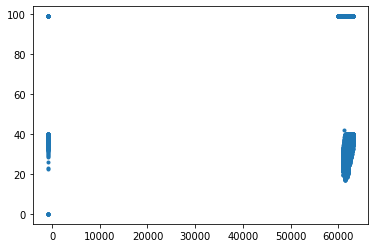

In [12]:
fig = plt.figure(figsize=(12,60))
number_of_subplots=len(modelname)
#print(number_of_subplots)
keep = -9*np.ones(len(modelname))
print(keep)

path = Path('../../alert_packet/python/lsst/alert/packet/schema/4/0/sample_data/')
with open(path/'alert.json') as f:
    alert_data_orig = json.load(f)

for countm,name in enumerate(modelname):
    print(name)
    # Open the photometry file and the header files
    name_head=simdir+'/'+name+'/'+'%s-0001_HEAD.FITS.gz'%name
    name_phot=simdir+'/'+name+'/'+'%s-0001_PHOT.FITS.gz'%name
    
#     name_head=simdir+name+'/'+'GSN_LSST_DDF_NONIaMODEL0-0001_HEAD.FITS.gz'
#     name_phot=simdir+name+'/'+'GSN_LSST_DDF_NONIaMODEL0-0001_PHOT.FITS.gz'
    head = fits.open(name_head)
    head_cols=head[1].columns
    #print(head_cols)
    phot = fits.open(name_phot)
    phot_cols=phot[1].columns
    #print(phot_cols)
    #plt.close('all')  
    # now take header information
    mjd = phot[1].data['MJD']
    mag = phot[1].data['SIM_MAGOBS']
    print()
    try:
        bound = np.where(mjd==-777)[0][0]-1
        print(bound, countm)
        if number_of_subplots==1:
             ax1 = plt.subplots(1,1)
        else: 
            ax1 = plt.subplot(number_of_subplots,1,countm+1)

        plt.plot(mjd, mag,'.')
        #plt.text(59600,45, '%s'%name)
        #plt.axis([59582.3282,59582.3282+399, 0,60])
        filt = phot[1].data['FLT'][0:bound]
        mag = phot[1].data['SIM_MAGOBS'][0:bound]
        ginds = np.where(phot[1].data['FLT'][0:bound]=='g')
        zinds = np.where(phot[1].data['FLT'][0:bound]=='z')
        fluxcal =  phot[1].data['FLUXCAL'][0:bound]
        fluxcalerr =  phot[1].data['FLUXCALERR'][0:bound]
        snr = fluxcal/fluxcalerr
        mjd=mjd[0:bound]
 
        # copy the original alert data and clear all old sources
        alert = copy(alert_data_orig)
        diasrc = alert_data_orig['prvDiaSources'][0]
        my_diasrc = copy(diasrc)
        alert = copy(alert_data_orig)
        alert['prvDiaSources'].clear()
        my_diasrc['diaSourceId'] = np.int(28132306237521+1000*np.random.uniform())
        my_diasrc = import_diasrc_from_fits(head, phot,my_diasrc,HOSTLIB_host,i=0)        
        alert['diaSource'] = my_diasrc
     
        for key in alert['diaSource']:
                print(key)
                
        print('-------')
        for count, i in enumerate(ginds[0]):
            my_diasrc = copy(diasrc)
            alert['prvDiaSources'].append(alert['diaSource'])
            my_diasrc['diaSourceId'] = my_diasrc['diaSourceId']+count+1
            my_diasrc = import_diasrc_from_fits(head, phot,my_diasrc,HOSTLIB_host,i)
            alert['diaSource'] = my_diasrc
        print('====') 
        avro_bytes = schema.serialize(alert)
        messg = schema.deserialize(avro_bytes)
        iterNum=0
        keep[countm]=int(countm)
        with open("plasticcAlert_%s_%i.avro"%(name,iterNum), "wb") as f:
            schema.store_alerts(f, [alert])
        print(f"Saving model {name} as plasticcAlert_{name}_{iterNum}.avro")
    except:
        print(f"This model {name} seems to have no data")
        keep[countm]=int(0)
    print(f"Done saving models")
    
    
    

In [13]:
#print(keep)
keep = np.where(keep!=-9)[0]
print(keep)


[0]


0 AGAGLIAN_ZTF_NONIaMODEL0
Reading /global/cscratch1/sd/rhlozek/alerts/plasticc_alerts/Examples/plasticcAlert_AGAGLIAN_ZTF_NONIaMODEL0_0.avro
diaSourceId huh did it work
ccdVisitId huh did it work
diaObjectId huh did it work
ssObjectId huh did it work
parentDiaSourceId huh did it work
midPointTai huh did it work
filterName huh did it work
programId huh did it work
ra huh did it work
decl huh did it work
raErr huh did it work
declErr huh did it work
ra_decl_Cov huh did it work
x huh did it work
y huh did it work
xErr huh did it work
yErr huh did it work
x_y_Cov huh did it work
apFlux huh did it work
apFluxErr huh did it work
snr huh did it work
psFlux huh did it work
psFluxErr huh did it work
psRa huh did it work
psDecl huh did it work
psRaErr huh did it work
psDeclErr huh did it work
psFlux_psRa_Cov huh did it work
psFlux_psDecl_Cov huh did it work
psRa_psDecl_Cov huh did it work
psLnL huh did it work
psChi2 huh did it work
psNdata huh did it work
trailFlux huh did it work
trailRa huh 

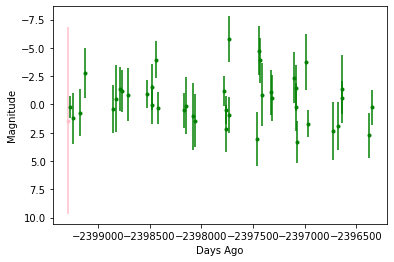

In [14]:
#print(keep)
for count in keep:
    iterNum=0
    print(count, modelname[count])
    
    fname= savedir+'/'+"plasticcAlert_%s_%i.avro"%(modelname[count],iterNum)
    print(f"Reading {fname}")
    with open(fname,'rb') as f:
        freader = DataFileReader(f,DatumReader())
        for alert in freader:
            for part in alert['diaSource']:
                print(part, 'huh did it work')
            dflc = make_dataframe(alert)
            plot_lightcurve(dflc)
            
            